In [1]:
import geemap

# Create a map and add the clipped NDVI map
Map = geemap.Map(basemap = 'SATELLITE')

Map.addLayerControl()
# Display the map
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
import ee

roi = ee.FeatureCollection(Map.draw_features)

plant_date = '2021-09-01'
har_date = '2022-07-20'

In [1]:
def ras_to_vec(state, county, year):
    
    state = str(state)
    county = str(county)
    year = str(year)

    if len(state) == 1:
        state = '0'+state

    if len(county) == 1:
        county = '00'+county
    elif len(county) == 2:
        county = '0'+county

    # Define the boundary of Thomas County, Kansas
    countyBoundary = ee.FeatureCollection('TIGER/2018/Counties') \
        .filter(ee.Filter.eq("STATEFP", state)) \
        .filter(ee.Filter.eq("COUNTYFP", county))

    start = year+'-01-01'
    end = year+'-12-31'
    # Load the CropScape data for the year 2022
    cropscape = ee.ImageCollection('USDA/NASS/CDL') \
        .filter(ee.Filter.date(start, end)) \
        .first()

    # Select winter wheat (crop code: 3) from the CropScape data
    winterWheat = cropscape.select('cropland') \
        .eq(24) \
        .selfMask()

    # Clip the winter wheat layer to Thomas County boundary
    winterWheatClip = winterWheat.clip(countyBoundary)
    
    # Convert the clipped layer to a FeatureCollection
    winterWheatFC = winterWheatClip.reduceToVectors(
        geometry=countyBoundary,
        scale=30,
        geometryType='polygon',
        eightConnected=False,
        labelProperty='class',
        maxPixels= 1e9
    )

    return countyBoundary, winterWheatFC


def get_mean_ndvi(start_date, end_date, countyBoundary, winterWheatFC): 
    
    if not(countyBoundary.size().getInfo()):
        return None

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
            .filterBounds(countyBoundary) \
            .filterDate(start_date, end_date) 

    sentinel2 = sentinel2.mosaic()

    combined_ndvi = sentinel2.normalizedDifference(['B8', 'B4'])

    clippedNDVI = combined_ndvi.clip(roi)

    ndvi_values = clippedNDVI.reduceRegion(reducer=ee.Reducer.toList(), geometry=winterWheatFC, bestEffort=True, scale=30).getInfo().get('nd')

    return ndvi_values

import datetime

def get_ndvi_serie(df):

    #start_date = datetime.datetime.strptime(plant_date, '%Y-%m-%d')
    #har_date = datetime.datetime.strptime(har_date, '%Y-%m-%d')


    df = df.copy()

    countyBoundary, winterWheatFC = ras_to_vec(df['State ANSI'], df['County ANSI'], df['Year'])

    year = df['Year']

    start_date = datetime.datetime(year-1, 8, 20)
    har_date = datetime.datetime(year, 8, 20)

    time_stamp = (har_date - start_date)/20

    ndvi_serie = []

    while start_date <= har_date:

        end_date = start_date + time_stamp - datetime.timedelta(days=1)

        ndvi_list = get_mean_ndvi(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), countyBoundary, winterWheatFC)
            
        ndvi_serie.append(ndvi_list)

        start_date = end_date + datetime.timedelta(days=1)

    return ndvi_serie

In [3]:
import pandas as pd

# Define the path to your CSV file
csv_file_path = r'data_preperation2015_2022_v20\data\usda_loss_wheatwinter_countylevel_2015_2022.csv'

# Load the CSV file into a dataframe
df = pd.read_csv(csv_file_path)
df

,Year,Period,Geo Level,State,State ANSI,Ag District,Ag District Code,County,County ANSI,Commodity,ACRES PLANTED,ACRES HARVESTED
0,2015,YEAR,COUNTY,ARKANSAS,5,CENTRAL,50,CONWAY,29,WHEAT,"6,300","2,500"
1,2015,YEAR,COUNTY,ARKANSAS,5,CENTRAL,50,PULASKI,119,WHEAT,"2,900","1,300"
2,2015,YEAR,COUNTY,ARKANSAS,5,EAST CENTRAL,60,ARKANSAS,1,WHEAT,"11,600","10,000"
3,2015,YEAR,COUNTY,ARKANSAS,5,EAST CENTRAL,60,CRITTENDEN,35,WHEAT,"28,400","24,000"
4,2015,YEAR,COUNTY,ARKANSAS,5,EAST CENTRAL,60,CROSS,37,WHEAT,"11,900","9,900"
...,...,...,...,...,...,...,...,...,...,...,...,...
7114,2022,YEAR,COUNTY,WISCONSIN,55,SOUTHEAST,90,WAUKESHA,133,WHEAT,"3,000","2,560"
7115,2022,YEAR,COUNTY,WISCONSIN,55,SOUTHWEST,70,CRAWFORD,23,WHEAT,"1,500","1,280"
7116,2022,YEAR,COUNTY,WISCONSIN,55,SOUTHWEST,70,RICHLAND,103,WHEAT,"1,500","1,280"
7117,2022,YEAR,COUNTY,WISCONSIN,55,SOUTHWEST,70,SAUK,111,WHEAT,"5,700","4,870"


In [4]:
import multiprocessing
import ee

for j in range(0, 100, 100):
    
    indices = range(j, j+100)

    if __name__ == '__main__':
        with multiprocessing.Pool(processes=25) as pool:
            result = pool.map(get_ndvi_serie, [df.iloc[i] for i in indices])

    ee.Reset()

In [26]:
start_date = datetime.datetime(2022, 8, 20)
start_date.strftime('%d %B')

'20 August'

In [8]:
import ee

ee.Initialize()

sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(roi) \
        .filterDate(plant_date, har_date)\
        .first()

combined_ndvi = sentinel2.normalizedDifference(['B8', 'B4'])

clippedNDVI = combined_ndvi.clip(roi)

pixel_values = clippedNDVI.reduceRegion(reducer=ee.Reducer.toList(), geometry=roi, scale=30).getInfo().get('nd')

In [47]:
import numpy as np
import ee
import matplotlib.pyplot as plt

ee.Initialize()

# Define your region of interest (roi) and the desired start and end dates

# Load the Sentinel-2 image collection and apply filters
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .filterDate(start_date, end_date) \
    .first()

# Calculate the combined NDVI
combined_ndvi = sentinel2.normalizedDifference(['B8', 'B4'])

# Clip the NDVI image to the region of interest
clippedNDVI = combined_ndvi.clip(roi)

# Convert clippedNDVI to a NumPy array
ndvi_array = np.array(clippedNDVI.sample(region=roi, scale=10).getInfo()['features'])

# Extract the NDVI values from the array
ndvi_values = np.array([feature['properties']['nd'] for feature in ndvi_array])

# Get the image dimensions
image_height = clippedNDVI.getInfo()['bands'][0]['dimensions'][0]
image_width = clippedNDVI.getInfo()['bands'][0]['dimensions'][1]

# Reshape the array to a 2D shape
ndvi_2d_array = ndvi_values.reshape((image_height, image_width))

# Display the NDVI map
plt.imshow(ndvi_2d_array, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI Map')
plt.show()


ValueError: cannot reshape array of size 2229 into shape (10980,10980)

In [42]:
# Convert the clippedNDVI image to a 2D NumPy array
ndvi_array = np.array(clippedNDVI.sample(region=roi, scale=10).getInfo()['features'])

In [39]:
from PIL import Image


ndvi_array = np.array(list_ndvi)

# Assuming 'clipped_ndvi' is the clipped NDVI image
resized_ndvi = ndvi_array.resize((500, 500))

In [40]:
resized_ndvi

In [58]:
import ee

ee.Initialize()

# Load a Sentinel-2 image within the AOI
image = ee.Image('COPERNICUS/S2_SR/20210525T185921_20210525T190125_T10SEG')

# Get the projection information of the image
projection_info = image.projection()

# Get the pixel size (resolution) from the projection information
pixel_size = projection_info.nominalScale()

# Print the pixel size (resolution)
print('Pixel Size (Resolution):', pixel_size.getInfo())


EEException: Image.load: Image asset 'COPERNICUS/S2_SR/20210525T185921_20210525T190125_T10SEG' not found.

In [24]:
pixel_values = clippedNDVI.reduceRegion(reducer=ee.Reducer.toList(), geometry=roi, scale=30)

In [25]:
pixel_values

In [26]:
ndvi_values = pixel_values.get('nd').getInfo()

In [27]:
ndvi_values

[0.15645483136177063,
 0.13918668031692505,
 0.14711730182170868,
 0.15780621767044067,
 0.17198336124420166,
 0.19540713727474213,
 0.13873282074928284,
 0.14667150378227234,
 0.18821504712104797,
 0.19301868975162506,
 0.20017081499099731,
 0.11660361289978027,
 0.12153846025466919,
 0.15420950949192047,
 0.17383721470832825,
 0.18432627618312836,
 0.19415877759456635,
 0.20297349989414215,
 0.23055966198444366,
 0.10287360846996307,
 0.10299419611692429,
 0.11717802286148071,
 0.14275434613227844,
 0.14836223423480988,
 0.1675417721271515,
 0.1788722574710846,
 0.1909693479537964,
 0.2223929762840271,
 0.24169425666332245,
 0.24362638592720032,
 0.26484790444374084,
 0.09948541969060898,
 0.1000390499830246,
 0.10283771902322769,
 0.10052406042814255,
 0.14204494655132294,
 0.15139879286289215,
 0.1666666716337204,
 0.1910112351179123,
 0.19790196418762207,
 0.2108345478773117,
 0.24253153800964355,
 0.24767521023750305,
 0.2467798888683319,
 0.26249563694000244,
 0.1060691103339195

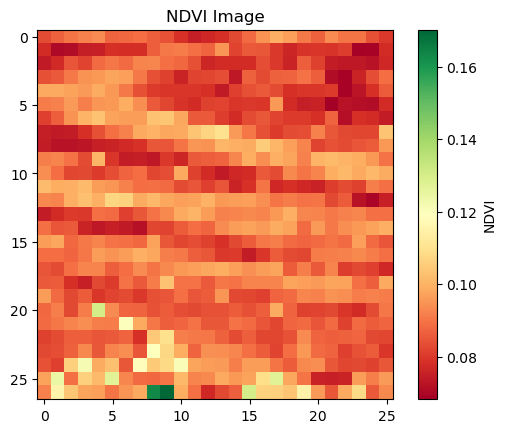

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the NDVI values to a NumPy array
ndvi_array = np.array(ndvi_values[3:])

# Reshape the NDVI array to match the image dimensions (e.g., width and height)
# Make sure to replace the width and height values with the appropriate dimensions
ndvi_array = ndvi_array.reshape(27, 26)

# Display the NDVI array as an image
plt.imshow(ndvi_array, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI Image')
plt.show()

In [10]:
ndvi_values = clippedNDVI.sampleRectangle(region=roi, defaultValue=0).getInfo()

In [17]:
import matplotlib.pyplot as plt
import urllib

# Get the thumbnail URL for the clippedNDVI image
thumbnail_url = clippedNDVI.getThumbURL({'min': -1, 'max': 1, 'palette': 'Red'})

# Read the image from the URL and display it
image = plt.imread(urllib.request.urlopen(thumbnail_url))
plt.imshow(image)
plt.title('Clipped NDVI Image')
plt.axis('off')
plt.show()


EEException: Image is unbounded. Must specify a region or a pixel grid with dimensions.